In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

Reload the light curve generated with the `3-light_curve_draft.ipynb` notebook:

In [2]:
lc = np.load("light_curve.npz")

In [3]:
# transforming the key names into arrays with the name of the column and with its values
for k in lc.keys():
    print (k)
    vars()[k] = lc[f'{k}']

excess_per_hour
excess_per_hour_err
mjd
mjd_min
mjd_max


Re-plot the light curve:

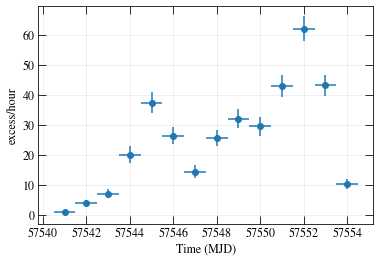

In [4]:
plt.errorbar(mjd, excess_per_hour,
             yerr=excess_per_hour_err,
             xerr=[mjd - mjd_min, mjd_max - mjd],
             ls='none', marker='o')
plt.ylabel('excess/hour')
plt.xlabel("Time (MJD)")
plt.grid(alpha=0.25)

Visit the <a href=https://fermi.gsfc.nasa.gov/ssc/data/access/lat/msl_lc/>weely monitored source list</a> page of the Fermi-LAT collaboration and browse to your source. Download the fits files for the weekly and daily light curves there or simply change the link below to the right location.

Daily light curve:

In [5]:
!curl https://fermi.gsfc.nasa.gov/FTP/glast/data/lat/catalogs/asp/current/lightcurves/1ES1959+650_86400.lc --output daily_lc.fits

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  317k  100  317k    0     0   186k      0  0:00:01  0:00:01 --:--:--  186k


Weekly light curve:

In [6]:
!curl https://fermi.gsfc.nasa.gov/FTP/glast/data/lat/catalogs/asp/current/lightcurves/1ES1959+650_604800.lc --output weekly_lc.fits

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72000  100 72000    0     0  63740      0  0:00:01  0:00:01 --:--:-- 63773


Open the light curve files and inspect their content

In [7]:
daily = Table.read("daily_lc.fits")
weekly = Table.read("weekly_lc.fits")

In [8]:
daily

START,STOP,NAME,RA,DEC,FLUX_1000_300000,ERROR_1000_300000,UL_1000_300000,FLUX_300_1000,ERROR_300_1000,UL_300_1000,FLUX_100_300000,ERROR_100_300000,UL_100_300000,DURATION,TEST_STATISTIC
s,s,,deg,deg,photons/cm**2/s,photons/cm**2/s,,photons/cm**2/s,photons/cm**2/s,,photons/cm**2/s,photons/cm**2/s,,s,
float64,float64,bytes12,float32,float32,float32,float32,bool,float32,float32,bool,float32,float32,bool,float32,float32
240019200.0,240105600.0,1ES 1959+650,300.0,65.149,2.9683543e-08,8.946118e-09,True,3.1296924e-08,2.360751e-11,True,2.342277e-07,2.300978e-09,True,86400.0,0.0
240105600.0,240192000.0,1ES 1959+650,300.0,65.149,1.4555055e-08,2.5389044e-12,True,8.4028386e-08,2.4757915e-08,True,3.5234922e-07,8.2566487e-07,True,86400.0,0.0
240192000.0,240278400.0,1ES 1959+650,300.0,65.149,4.17676e-08,1.1685102e-08,True,3.4367602e-08,1.3299925e-11,True,1.4395637e-07,2.1996933e-10,True,86400.0,0.0
240278400.0,240364800.0,1ES 1959+650,300.0,65.149,1.5900813e-08,3.1649984e-13,True,7.0554336e-08,2.144413e-08,True,1.5251545e-07,5.294928e-08,True,86400.0,0.8331939
240364800.0,240451200.0,1ES 1959+650,300.0,65.149,1.8311582e-08,3.717945e-07,True,1.3575502e-07,4.0974587e-08,True,2.654991e-07,1.05335346e-07,True,86400.0,0.40181798
240451200.0,240537600.0,1ES 1959+650,300.0,65.149,1.4631377e-08,7.811952e-12,True,9.371189e-08,3.1425916e-08,True,5.1875855e-07,1.8436295e-07,True,86400.0,3.4749458
240537600.0,240624000.0,1ES 1959+650,300.0,65.149,6.378682e-08,1.666346e-08,True,1.4305894e-07,4.5609887e-08,True,3.834552e-07,1.1759655e-07,True,86400.0,9.65693
240624000.0,240710400.0,1ES 1959+650,300.0,65.149,1.7176264e-08,7.035659e-13,True,8.855653e-08,2.624661e-08,True,1.2215114e-07,2.8323281e-09,True,86400.0,0.0


### Plot the Fermi and FACT light curves


Plot the daily (or weekly) Fermi light curves and FACT light curve. 

For the Fermi light curve, the `TEST_STATISTIC` columns indicates the signficance with which the source is detected in each time bin. The significance in standard deviations is roughly given as the square root of the test statistic. If the source is below a certain threshold, plot the upper limit value instead. 

In [9]:
# function to convert Fermi mission time (MET) to MJD
def met_to_mjd(time):
    """"Convert mission elapsed time to mean julian date."""
    return 54682.65 + (time - 239557414.0) / (86400.)

In [10]:
def plot_fermi_lc(lc,
                  ts_thr=9.,
                  tmin_mjd=0, 
                  tmax_mjd=1e10,
                  ax=None,
                  **kwargs
                  ):
    """
    Plot a fermi light curve
    
    Parameters
    ----------
    lc: `astropy.table.Table`
        light curve table
        
    ts_thr: float
        threshold TS value.
    
    tmin_mjd: float
        minimum time in MJD for which light curve is displayed
        
    tmax_mjd: float
        maximum time in MJD for which light curve is displayed
    """
    kwargs.setdefault('ls', 'none')
    kwargs.setdefault('marker', 's')
    kwargs.setdefault('ms', 5)
    kwargs.setdefault('color', plt.cm.tab10(0.1))
    
    if ax is None:
        ax = plt.gca()
        
    tcen = 0.5 * (met_to_mjd(lc['START']) + met_to_mjd(lc['STOP']))
    tmin = met_to_mjd(lc['START'])
    tmax = met_to_mjd(lc['STOP'])
    
    # mask for time range
    mt = (tmin >= tmin_mjd - 1.) & (tmax <= tmax_mjd + 1.)
    if not np.sum(mt):
        raise ValueError("No data in requested time range")
    
    # mask for detection or upper limit
    m = (lc['TEST_STATISTIC'] >= ts_thr) & mt
    mul = (lc['TEST_STATISTIC'] < ts_thr) & mt
    
    y = lc['FLUX_100_300000']
    dy = lc['ERROR_100_300000']
    if np.sum(m):
        ax.errorbar(tcen[m], y[m],
                    yerr=dy[m], 
                    xerr=[tcen[m] - tmin[m], tmax[m] - tcen[m]],
                    **kwargs
                    )
    if np.sum(mul):
        ax.errorbar(tcen[mul], y[mul],
                    yerr=y[mul] / 4., 
                    xerr=[tcen[mul] - tmin[mul], tmax[mul] - tcen[mul]],
                    uplims=True, **kwargs
                    )
    ax.set_ylabel("Flux (cm$^{-2}$ s$^{-1}$)")
    
    return tcen, tmin, tmax, y, dy, m

Plot the two light curves on top of each other. From this one can already judge 'by eye' if there's some correlated variability between the FACT and Fermi-LAT energy bands. 

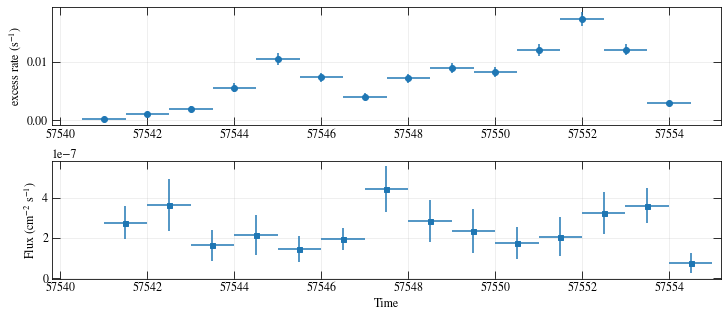

In [11]:
fig = plt.figure(figsize=(12,5))

ax = plt.subplot(211)

plt.errorbar(mjd, excess_per_hour / 3600.,
             yerr=excess_per_hour_err / 3600.,
             xerr=[mjd - mjd_min, mjd_max - mjd],
             ls='none', marker='o')
ax.set_ylabel('excess rate (s$^{-1}$)')
ax.grid(alpha=0.25)
v = ax.get_xlim()

ax = plt.subplot(212)
tcen_fermi, tmin_fermi, tmax_fermi, y_fermi, dy_fermi, m_fermi = plot_fermi_lc(
    daily, color=plt.cm.tab10(0.), tmin_mjd=mjd.min(), tmax_mjd=mjd.max(), ax=ax, ts_thr=9.)
ax.grid(alpha=0.25)
ax.set_xlabel('Time')
ax.set_xlim(v)

fig.subplots_adjust(hspace=0.3)

### Apply a Bayesian block analysis to the data

We can apply the Bayesian block algorithm to the data (<a href=https://ui.adsabs.harvard.edu/abs/2013ApJ...764..167S>Scargle et al. (2013)</a>). If more than one block is detected, this means that some variability seems to be present in the data. We can also use this algorithm to try to separate multiple flares from each other. For the algorithm, we will assume that the errors follow Gaussian statistics. See also the <a href=https://docs.astropy.org/en/stable/api/astropy.stats.bayesian_blocks.html>documentation</a>.


In [12]:
from astropy.stats import bayesian_blocks

Apply the algorithm to the data. The algorithm returns the time edges where a new block starts.

In [13]:
edges_fact = bayesian_blocks(mjd, excess_per_hour, sigma=excess_per_hour_err, fitness='measures')
edges_fermi = bayesian_blocks(tcen_fermi[m_fermi], y_fermi[m_fermi], sigma=dy_fermi[m_fermi], fitness='measures')

Calculate the mean flux per block by looping over the block edges:

In [14]:
def calc_mean_flux(edges, t, y):
    
    y_mean = np.zeros_like(edges[:-1])
    t_cen = np.zeros_like(edges[:-1])
    
    for i, e in enumerate(edges[:-1]):
        m = (t >= e) & (t <= edges[i+1])
        y_mean[i] = y[m].mean()
        t_cen[i] = t[m].mean()
        
    return t_cen, y_mean

In [15]:
t_bb_fact, y_bb_fact = calc_mean_flux(edges_fact, mjd_min, excess_per_hour / 3600.)
t_bb_fermi, y_bb_fermi = calc_mean_flux(edges_fermi, tcen_fermi[m_fermi], y_fermi[m_fermi])

Plot the light curves, superimposed with the bayesian-block representation

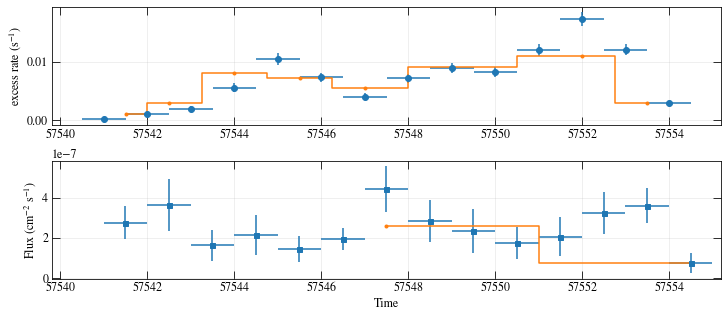

In [16]:
fig = plt.figure(figsize=(12,5))

ax = plt.subplot(211)

# FACT data
plt.errorbar(mjd, excess_per_hour / 3600.,
             yerr=excess_per_hour_err / 3600.,
             xerr=[mjd - mjd_min, mjd_max - mjd],
             ls='none', marker='o')

# FACT Bayesian blocks
ax.plot(t_bb_fact, y_bb_fact,
        drawstyle='steps-mid', marker='.')


ax.set_ylabel('excess rate (s$^{-1}$)')
ax.grid(alpha=0.25)
v = ax.get_xlim()

ax = plt.subplot(212)
# Fermi data
plot_fermi_lc(daily, color=plt.cm.tab10(0.), tmin_mjd=mjd.min(), tmax_mjd=mjd.max(), ax=ax, ts_thr=9.)

# Fermi Bayesian blocks
ax.plot(t_bb_fermi, y_bb_fermi, drawstyle='steps-mid', marker='.', color=plt.cm.tab10(0.1))

ax.grid(alpha=0.25)
ax.set_xlabel('Time')
ax.set_xlim(v)

fig.subplots_adjust(hspace=0.3)

There seems to be more variability in the FACT light curve that does not match the observed variability pattern in the Fermi data. 

### Fit an exponential rise and decay profile to the FACT data

We use <a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html> `scipy.optimize.curve_fit` </a> to estimate the best-fit parameters.

In [17]:
from scipy.optimize import curve_fit

From the Bayesian block representation, it seems that there are two flares present in the data: one before MJD 57547 and one afterwards. We focus on the time before MJD 57547. For this time range, we want to fit an exponential rise and decay function to the excess light curve. This function can be defined as follows:

$$F(t) = \frac{2F_0}{\exp((t-t_0)/\tau_\mathrm{rise}) + \exp((t_0-t)/\tau_\mathrm{decay})},$$

with free parameters $F_0$, $t_0$, as well as the rise and decay times $\tau_\mathrm{rise}$ and $\tau_\mathrm{decay}$.

First define the fitting function:

In [24]:
def f(t, *p):
    m = t < p[1]
    result = np.zeros_like(t)
    result[m] = p[0] * np.exp((t[m]-p[1]) / p[2])
    result[~m] = p[0] * np.exp(-(t[~m]-p[1]) / p[3])
    return result

In [25]:
m_flare = (mjd < 57548)  # limit the time range

A first inital guess:

In [58]:
trise = 1.3
tdecay = 2.5
f0 = excess_per_hour[m_flare].max()
t0 = mjd[m_flare][np.argmax(excess_per_hour[m_flare])]

pinit = [
    f0, 
    t0,   # time of the peak
    trise,  # rise time
    tdecay,  # decay time
]

In [59]:
 mjd[m_flare][np.argmax(excess_per_hour[m_flare])]

57545

In [78]:
popt, pcov = curve_fit(f, mjd[m_flare],
                       excess_per_hour_err[m_flare],
                       sigma=excess_per_hour_err[m_flare],
                       p0=[1., t0-1, 1., 1.],
                       absolute_sigma=True
                      )

Plot the best fit

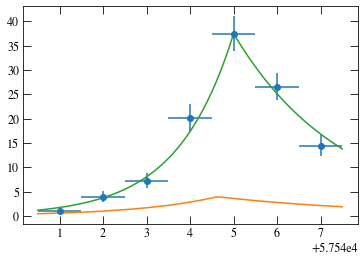

In [79]:
# FACT data
plt.errorbar(mjd[m_flare],
             excess_per_hour[m_flare],
             yerr=excess_per_hour_err[m_flare],
             xerr=[mjd[m_flare] - mjd_min[m_flare], mjd_max[m_flare] - mjd[m_flare]],
             ls='none', marker='o')

x = np.arange(mjd_min[m_flare].min(), mjd_max[m_flare].max() + 0.1, 0.1)
plt.plot(x, f(x, *popt))
plt.plot(x, f(x, *pinit))

Number of degrees of freedom:

In [62]:
dof = mjd[m_flare].size - len(popt)

Print the reduced $\chi^2$:

In [63]:
# initial parameters:
print (np.sum(((excess_per_hour[m_flare] - f(mjd[m_flare], *pinit)) / (excess_per_hour_err[m_flare]))**2.) / dof)

# final parameters:
print (np.sum(((excess_per_hour[m_flare] - f(mjd[m_flare], *popt)) / (excess_per_hour_err[m_flare]))**2.) / dof)

1.0268758810217047
92.24262529679639


This is not really working yet, probably because fit can't find a good minimum. Still needs some work. 

In [64]:
print (popt)

[3.94438552e+00 5.75446239e+04 1.89179119e+00 3.85449438e+00]


In [65]:
print (pcov)

[[ 1.09005553e+01  2.42591755e+00 -1.94780621e+00 -2.71156363e+01]
 [ 2.42591755e+00  3.90307839e+00  1.90326362e+00 -1.30081751e+01]
 [-1.94780621e+00  1.90326362e+00  2.52788168e+00  9.14028131e-08]
 [-2.71156363e+01 -1.30081751e+01  9.14028142e-08  1.10674445e+02]]
